In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

# data_dir = '/Users/SY/Desktop/obic/data/'
data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [11]:
#read as pandas
starcatalog_fram = pd.read_csv(data_dir + 'lamost_sdss_new2.csv')

###########

#starcatlog_fram = starcatlog_fram.ix[:,:517]
#print(starcatalog_fram)

In [12]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'parsec_fnugriz.csv')

############

#print(parsec_fram.values)

In [13]:
### Elective CHOICE

########### I.
#change logTeff into Teff.

# def tenn(x):
#     y=10 ** x
#     return y

# Teff_tbl = starcatalog['logTeff'].apply(tenn)
###########

########### II.
#add [Teff] into DATAFRAME

#data_fram = starcatalog_fram[['TEFF_1','ERR_TEFF_1','Jmag_1','e_Jmag_1','Hmag_1','e_Hmag_1']]
#print(data_fram)
###########

########### III.
# fill the NaN blocks with 0

starcatalog_fram_fil = starcatalog_fram.fillna(0)

#print(starcatalog_fram_fil['LOGG'])
############


In [14]:
starcatalog_fram_fil.columns

Index(['col1', 'TEFF', 'ERR_TEFF', 'RA', 'DEC', 'LOGG', 'ERR_LOGG', 'RAdeg',
       'DEdeg', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'objID', 'mode',
       'q_mode', 'class', 'SDSS12', 'm_SDSS12', 'flags', 'ObsDate', 'Q',
       'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag',
       'zmag', 'e_zmag', 'zsp', 'e_zsp', 'f_zsp', 'zph', 'e_zph', 'avg_zph',
       'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'SpObjID', 'spType', 'spCl',
       'subClass', 'angDist'],
      dtype='object')

In [71]:
### variables

teff = 'TEFF'

color1 = 'gmag'
color2 = 'rmag'
err_teff = 'ERR_TEFF'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2
#'ERR_' + color2
#'e_' + color2

In [72]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.7

starcatalog_fram_fil = starcatalog_fram_fil[(starcatalog_fram_fil['LOGG']>3.0)]
parsec_fram = parsec_fram[(parsec_fram['logg']>3.0)]                                            

In [73]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] != -99) \
                                          & (starcatalog_fram_fil[err_c2] != -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.05)\
                                          & (starcatalog_fram_fil[err_c2] <=0.05))]
### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

print(starcatalog_fram_fil.iloc[:,0].size)

12515


In [74]:
### draw the png of errTeff 

# plt.figure(3)
# plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
# plt.ylabel('$σ_\mathrm{Teff}$',fontsize=14)
# plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
#             c='steelblue',s=8, edgecolors='None',alpha=0.2,label='$σ_\mathrm{Teff}$(LAMOST)')
# plt.legend(loc='lower right')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig(savename3,dpi=200)  
# plt.show()

### 

In [75]:
# cut source g-r:0.440
origin = starcatalog_fram_fil
starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2]>= -0.440)\
                                         & (starcatalog_fram_fil[color1]>=12)]

In [76]:
#filt the good one
#apogee_tbl_fil = apogee_tbl[np.argwhere(np.logical_and(apogee_tbl['teff'] > 0, apogee_tbl['logg'] > -3))]
#apogee_tbl_fil = apogee_tbl_fil[np.argwhere(np.logical_and(apogee_tbl_fil['j'].flatten() > -1, \
#                                                           apogee_tbl_fil['h'].flatten() > -1))]
#USE goodOB 


starcatalog_fram_fil=starcatalog_fram_fil[(((starcatalog_fram_fil[err_teff] != 0 )\
                                          & (starcatalog_fram_fil[teff]>= 10000))\
                                          #& (starcatalog_fram_fil[teff]<= 16000))
                                          & (((starcatalog_fram_fil[err_teff]< 630)\
                                          &(starcatalog_fram_fil[teff]> 9000))\
                                          |((starcatalog_fram_fil[err_teff]< 500)\
                                          & (starcatalog_fram_fil[teff]<= 9000))))]
print(np.max(starcatalog_fram_fil[teff]))

25767.258


In [77]:
# Determine the input numbers.

# Bin width, usually 50 (for more scatter, try 1000 or other figures)
#bin_width = 1000
# Ratio of the bluest edge, usually 5%
rat = 5
# Low end criteria. If the number in a bin is lower than this number then neglect.  
low_crit = 50

In [78]:
# input the data of Bessell. M.S. & Brett. J.M. 1988
# BBFrame is the dataframe of the ic data 

BBFrame=pd.DataFrame({'J-H':[-0.09,-0.08,-0.07,-0.06,-0.05,-0.03,-0.03,-0.01,0.0,0.02,0.06],\
                      'Teff':[22300,19000,17200,15400,14100,13000,11800,10700,9480,8810,8160]})


In [79]:
# parsec point
parsecframe = parsec_fram[((parsec_fram['Age'] == 3980000)\
                           &(parsec_fram['logTe'] <= 4.361)\
                           &(parsec_fram['logTe'] >= 4.000))]
parsec_teff =10**parsecframe['logTe'] 
parsec_color = parsecframe[color1] - parsecframe[color2]
#print(parsecframe.values)
                                         

In [80]:
# SFD point for now we just run the conpile of J-H
SFDframe = pd.read_csv('SFD_teffJH.csv')
SFD_JH_teff = SFDframe['TEFF']
SFD_JH_ic = SFDframe['J-H']


In [81]:
# Find the start point and bin number of Teff. 
# Start point: the first number divisible by bin_width smaller than min(teff)
# Bin number: Start from start point and cover all the teff range.


#teff_start = min(apogee_tbl_fil['teff']) - min(apogee_tbl_fil['teff']) % (bin_width/2)
#bin_number = math.ceil((max(apogee_tbl_fil['teff']) - teff_start) / bin_width)

#teff_start = min(starcatalog_fram_fil[teff])-min(starcatalog_fram_fil[teff])%(bin_width / 2)

teff_start= 10000

#bin_number = math.ceil((max(starcatalog_fram_fil[teff])-teff_start) / bin_width)


In [82]:
#filt BBFrame
BBFrame_fil=BBFrame[BBFrame['Teff'] >= teff_start]

In [83]:
def data(teff_start,ratio,low_crit):
    Nwind = 0
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    bin_teff_5 = []; bin_RA_5 = []; bin_DEC_5 = []; bin_color1_5 = []; bin_color2_5 = [];
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 1000:
        Nwind += 1
#         print(Nwind)
        
        if teff_judge <9000:
            bin_width = 100
        else:
            bin_width = 630

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+bin_width
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)
        #             bin_mean = np.mean(bin_tbl[color1]-bin_tbl[color2])
        #             bin_sigma = np.std(bin_tbl[color1]-bin_tbl[color2])
        #             bin_tbl = bin_tbl[np.logical_and(bin_tbl[color1]-bin_tbl[color2] < bin_mean+3*bin_sigma, \
        #                                       bin_tbl[color1]-bin_tbl[color2] > bin_mean-3*bin_sigma)]


        #bin_final = bin_tbl[[teff,color1,color2]]
        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        for PPP in range(len(bin_tbl_5['TEFF'])):
        
            bin_teff_5.append(bin_tbl_5['TEFF'].values[PPP]); 
            bin_RA_5.append(bin_tbl_5['RA'].values[PPP]);
            bin_DEC_5.append(bin_tbl_5['DEC'].values[PPP])
            bin_color1_5.append(bin_tbl_5[color1].values[PPP])
            bin_color2_5.append(bin_tbl_5[color2].values[PPP])
            
#         print(bin_tbl_final['TEFF'][0],bin_tbl_5['TEFF'][0])
        
#         print(bin_tbl_final)
        
#         print(bin_tbl_5)

        if len(color5) != 0:
            bin_mean = np.median(color5)
            bin_sigma = np.std(color5)
            bin_int_color = color5\
            [((color5<= bin_mean+3*bin_sigma)\
            & (color5>= bin_mean-3*bin_sigma))]

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+bin_width
        
#    print(teff_judge)

    bin_tbl_final = pd.DataFrame({'TEFF':np.array(bin_teff_5),'RA':np.array(bin_RA_5),\
                                  'DEC':np.array(bin_DEC_5),color1:np.array(bin_color1_5),\
                                 color2:np.array(bin_color2_5)})
    
    print(time.time() - start_time)
    print(int_teff,int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,bin_tbl_final

In [84]:
# fitting curve
int_teff,int_color,data_final,bin_tbl_final = data(teff_start,rat,low_crit)
fc = np.polyfit(int_teff, int_color, 3)#用3次多项式拟合
fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式
colorvals=fitcurve(int_teff)
# print(len(colorvals),len(int_teff))
#print(len(bin_tbl_final[teff].values))

bin_tbl_final[teff]


/Users/dengdingshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dengdingshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


1.2022759914398193
[10315.0, 10945.0, 11575.0, 12205.0, 12835.0, 13465.0, 14095.0, 14725.0, 15355.0, 15985.0, 16615.0, 17245.0, 17875.0, 18505.0, 19135.0, 19765.0, 20395.0, 21025.0, 21655.0, 22285.0] [-0.29499999999999993, -0.3254999999999999, -0.3420000000000023, -0.32299999999999685, -0.3879999999999999, -0.3800000000000008, -0.3520000000000003, -0.41300000000000026, -0.4339999999999975, -0.4339999999999975, -0.3080000000000007, -0.18750000000000178, -0.2104999999999997, -0.38400000000000034, -0.18100000000000094, -0.375, -0.4079999999999995, -0.4079999999999995, -0.40300000000000225, -0.3620000000000001]


0      10269.046
1      10190.198
2      10048.559
3      10319.974
4      10597.497
5      10334.392
6      10582.068
7      10200.546
8      10434.069
9      10153.466
10     10120.340
11     10339.875
12     10071.809
13     10042.080
14     10015.599
15     10088.650
16     10352.046
17     10270.865
18     10114.573
19     10497.596
20     10491.685
21     10570.653
22     10257.835
23     10389.645
24     10002.830
25     10092.327
26     10468.207
27     10305.752
28     10339.705
29     10077.418
         ...    
608    19433.662
609    18967.613
610    19549.207
611    19968.781
612    19939.672
613    19998.664
614    19509.780
615    19787.252
616    19597.086
617    20004.030
618    19604.756
619    20077.816
620    19498.006
621    19495.970
622    19610.023
623    19550.516
624    20054.166
625    20653.492
626    20681.242
627    20701.780
628    20403.754
629    21064.076
630    20743.598
631    21120.982
632    21681.240
633    21441.133
634    21372.230
635    22129.4

In [85]:
## use SFD dustmap
from __future__ import print_function
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

## ebv前的系数需要去文献中拿到。目前使用的是r和i的
Const1 = 3.303#g #2.285 #r 
Const2 = 2.285#r #1.698 #i

time_start = time.time()
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(bin_tbl_final)
print(lens)
for i in range(lens):
    coords = SkyCoord(bin_tbl_final['RA'].values[i],bin_tbl_final['DEC'].values[i],\
                      frame = 'icrs',unit = 'deg')
    ebv = sfd(coords)
    A_c1 = Const1*ebv;
    A_c2 = Const2*ebv;
    SFD_colorindex = bin_tbl_final[color1].values[i] - A_c1\
    - (bin_tbl_final[color2].values[i] - A_c2)
    SFD_catalog_color.append(SFD_colorindex)
    
    SFD_catalog_teff.append(bin_tbl_final[teff].values[i])
    
    print(i)

print(time.time() - time_start)

638
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [87]:
### figures & Savename
cc1 = 'g'
cc2 = 'r'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + '3'+'.png'
savename2 = save + date_now + cc1 + '_HR_' + cc2 +'.png'
savename3 = save + date_now + 'errteff.png'
savename5 = save + date_now + cc1 + cc2 + '3'+'ylim'+'.png'

savename_SFD_JH_only = save + date_now + 'SFD_JH' + '.png'
savename_SFD_JH_totle = save + date_now + 'SFD_JH_LAMOST_ylim' + '.png'

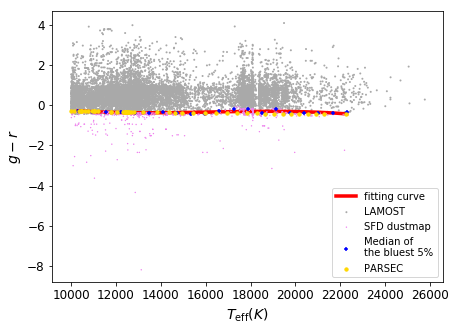

In [89]:
#PLT
plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
#plt.ylim(-4,9)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST')

# ic from SFD dustmap
plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='violet',s=2,label='SFD dustmap',zorder=2)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.5,label='fitting curve',zorder=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

# ic from parsec
plt.scatter(parsec_teff,parsec_color,c='gold',s=11,label='PARSEC',zorder=2)

### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='#FF6666',s=11,label='Allen')

plt.legend(loc='lower right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
# plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#         np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(savename1,dpi=200)
# plt.savefig(savename5,dpi=200)
plt.show()

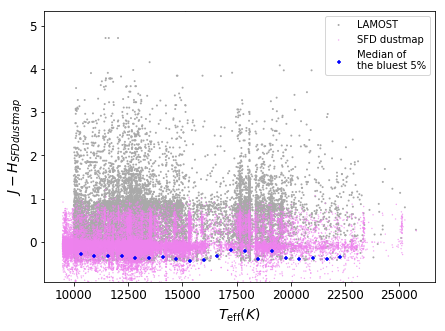

In [47]:
# draw SFD JH total
plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel('$J-H_{SFD dustmap}$',fontsize=14)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST')

plt.scatter(SFD_JH_teff,SFD_JH_ic,alpha=0.7,edgecolors='None',c='violet',s=2,label='SFD dustmap',zorder=2)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

plt.legend(loc='upper right')

#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
        np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(savename_SFD_JH_totle,dpi=200)
plt.show()

5


/Users/dengdingshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dengdingshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


1.1895029544830322
[10315.0, 10945.0, 11575.0, 12205.0, 12835.0, 13465.0, 14095.0, 14725.0, 15355.0, 15985.0, 16615.0, 17245.0, 17875.0, 18505.0, 19135.0, 19765.0, 20395.0, 21025.0, 21655.0, 22285.0, 22915.0] [-0.036000000000001364, -0.05099999999999838, -0.045999999999999375, -0.052499999999999325, -0.04800000000000004, -0.04800000000000004, -0.05099999999999927, -0.05599999999999916, -0.06700000000000195, -0.0519999999999996, 0.012000000000000455, -0.022999999999999687, 0.027999999999998693, -0.049999999999998934, -0.0420000000000007, -0.11800000000000033, -0.04100000000000037, 0.005999999999998451, -0.04899999999999949, 0.02400000000000091, 0.0019999999999988916]


ValueError: too many values to unpack (expected 3)

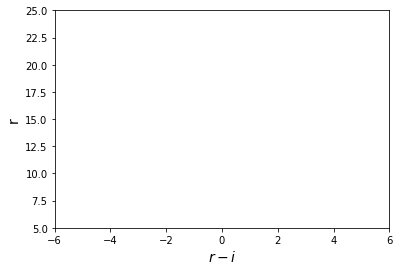

In [150]:
# H-R 1
plt.figure(2)
plt.xlabel(ylabel,fontsize=14); plt.ylabel(cc1,fontsize=14)
plt.xlim(-6,6)
plt.ylim(5,25)
# for rat in ratio:
print(rat)
int_teff,int_color,data_final = data(teff_start,rat,low_crit)

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(origin[color1]-origin[color2], origin[color1],\
            c= 'darkgray',s=5,edgecolors = 'None',alpha = 1,cmap=cm,label='all sources')
plt.scatter(data_final[color1]-data_final[color2], data_final[color1],\
             c='g',s=5, edgecolors='None', alpha=1,label='selected sources')
#plt.colorbar(sc)
plt.legend(loc='upper right')
# new_ticks = np.linspace(-2,3,18)
# plt.xticks(new_ticks)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(savename2,dpi=200)    
plt.show()

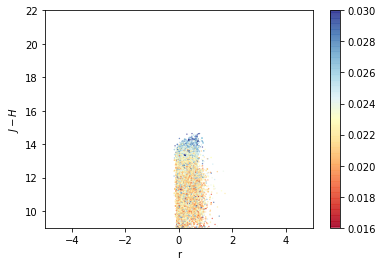

In [43]:
# 赫罗图 2
plt.xlabel('r')
plt.ylabel(ylabel)

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],starcatalog_fram_fil[color1],\
            c = starcatalog_fram_fil[err_c1],s=2,edgecolors = 'None',alpha = 0.7,cmap=cm)

plt.colorbar(sc)

plt.xlim(-5,5)
plt.ylim(9,22)
plt.savefig(save+'HR.png',dpi=200)
plt.show()

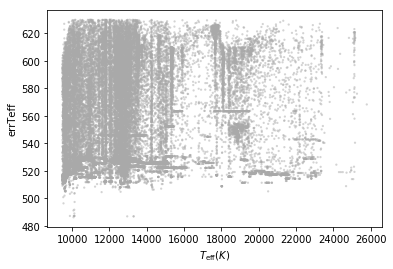

In [44]:
plt.figure(3)
plt.xlabel('$T_\mathrm{eff}(K)$')
plt.ylabel('errTeff')
plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
            c='darkgray',s=5, edgecolors='None', alpha=0.5)
plt.show()